In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [30]:
with open('/content/drive/My Drive/SVM/SMSSpamCollection', 'r') as f:
    data = f.read()

In [31]:
# Ensure necessary NLTK packages are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
# Convert the sample data into a DataFrame
from io import StringIO
df = pd.read_csv(StringIO(data), sep='\t', header=None, names=['label', 'text'])

In [33]:
# Label Encoding
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Text Cleaning Function
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply the cleaning function
df['cleaned_text'] = df['text'].apply(clean_text)

# Tokenization
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

# Remove Stop Words and Lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(tokens):
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    return tokens

df['processed_tokens'] = df['tokens'].apply(preprocess_text)

# Convert tokens back to string for vectorization
df['processed_text'] = df['processed_tokens'].apply(lambda x: ' '.join(x))

In [34]:
# Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_text'])
y = df['label']

In [35]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [36]:
# Train a Linear Kernel SVM
svm = SVC(kernel='linear', probability=True)  # Set probability=True to enable probability estimates
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class

In [37]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       0.98      0.87      0.92       224

    accuracy                           0.98      1672
   macro avg       0.98      0.93      0.96      1672
weighted avg       0.98      0.98      0.98      1672

Confusion Matrix:
[[1445    3]
 [  29  195]]


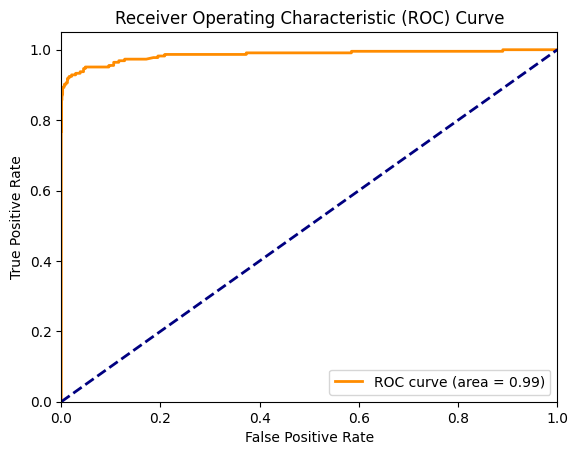

In [38]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()